In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train','test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [6]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [7]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


CIFAR-10 데이터셋을 받았으니 이제 Normalization을 진행한다

Data Normalization을 진행하는 이유

--> 머신러닝에서 scale이 큰 feature의 영향이 비대해지는것을 방지하고, 딥러닝에서 local optimum에 빠지는 위험 줄인다(학습 속도 향상!)

 scikit-learn에서 MinMaxScaler로 쉽게 사용 할 수 있어요.

In [5]:
def normalize_and_resize_img(image, label):
    """Normalize images: 'uint8' -> 'float32'."""
    # image = tf.image.resize(image, [32,32])
    return tf.cast(image, tf.float32) / 255., label

tf.cast를 통해 image를 float32 부동소수점식으로 변환한뒤 255로 나누어 정규화를 진행한 이미지 데이터와 정답값 label을 return한다.

그다음 이 normalize를 dataset에 적용시켜야 한다

In [28]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds
    
    

This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

--> 현재 요소가 처리중일 때, 나중 요소가 준비되게끔 한다  -> 지연성과 처리율 개선

In [10]:
ds_info.features["label"].num_classes

10

In [11]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

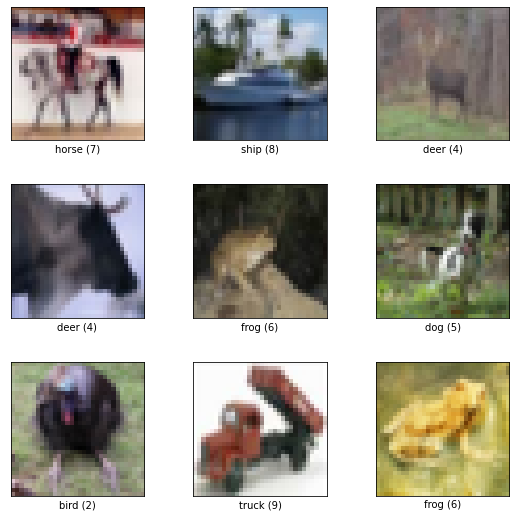

In [12]:
fig = tfds.show_examples(ds_train,ds_info)

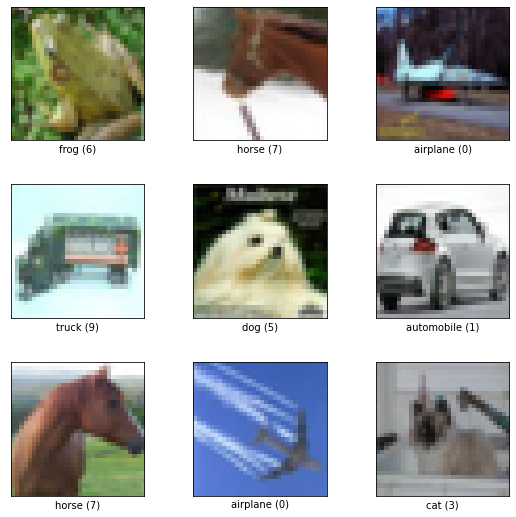

In [13]:
fig = tfds.show_examples(ds_test, ds_info)

데이터셋 train과 test데이터를 모두 모았으니 모델 구성을 시작해야한다

모델 내 구성되어있는 layer층들의 반복되는 부분을 줄여서 하이퍼파라미터 또는 변수를 변경해야 할 때 손쉽게 바꿀수 있게 해야한다

# VGG block modeling

In [14]:
#VGG Block build

def build_vgg_block(input_layer, num_cnn=3, channel=64, block_num=1,):
    #입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        
    #Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size = (2,2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)
    
    return x

vgg block 을 구성해 input layer만 내가 넣을 데이터셋에 맞게 설정만 해주면 된다

In [15]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))
vgg_block_output = build_vgg_block(vgg_input_layer)

In [16]:
#블록 1개짜리 (cnn 여러개, maxpooling 1개) 모델 생성하기
model = keras.Model(inputs= vgg_input_layer, outputs = vgg_block_output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


블록만들수 있는 함수를 만들었으니 이를 통해 전체 모델을 만들어야 한다

# VGG16

In [19]:
def build_vgg(input_shape=(32,32,3),
            num_cnn_list=[2,2,3,3,3],
             channel_list=[64,128,256,512,512],
             num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) # 모델 만들기 전에, config list들이 같은 길이인지 확인하자
    
    #인풋과 아웃풋 동일한 크기로 만듬
    input_layer =keras.layers.Input(shape=input_shape)
    output=input_layer
    
    #config list들의 길이만큼 반복해서 블록 생성한다
    
    for i, (num_cnn,channel) in enumerate(zip(num_cnn_list, channel_list)):
        output= build_vgg_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i,
        )
    
    output=keras.layers.Flatten(name='flatten')(output)
    output=keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
            inputs=input_layer,
            outputs=output
    )
    return model

    
    
    
    

In [20]:
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [24]:
vgg_19 = build_vgg(
        num_cnn_list=[2,2,4,4,4],
        channel_list=[64,128,256,512,512]
)
vgg_19.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

위에서 구성한 VGG16과 VGG19모델의 성능비교를 하겠다.

그러기위해서 다시 데이터셋을 불러와 정규화부터 실행한다


In [25]:
BATCH_SIZE = 256
EPOCH = 15


In [29]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train','test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)



In [34]:
vgg_16.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

In [35]:
history16 = vgg_16.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 71s 134ms/step - loss: 2.1832 - accuracy: 0.1893 - val_loss: 2.0535 - val_accuracy: 0.2412
Epoch 2/15
195/195 [==============================] - 24s 124ms/step - loss: 1.9847 - accuracy: 0.2786 - val_loss: 1.9551 - val_accuracy: 0.2615
Epoch 3/15
195/195 [==============================] - 24s 124ms/step - loss: 1.8558 - accuracy: 0.3315 - val_loss: 1.7735 - val_accuracy: 0.3647
Epoch 4/15
195/195 [==============================] - 24s 124ms/step - loss: 1.7515 - accuracy: 0.3704 - val_loss: 1.7116 - val_accuracy: 0.3811
Epoch 5/15
195/195 [==============================] - 24s 123ms/step - loss: 1.6743 - accuracy: 0.4013 - val_loss: 1.6130 - val_accuracy: 0.4279
Epoch 6/15
195/195 [==============================] - 24s 124ms/step - loss: 1.6111 - accuracy: 0.4216 - val_loss: 1.6392 - val_accuracy: 0.4149
Epoch 7/15
195/195 [==============================] - 24s 124ms/step - loss: 1.5533 - accuracy: 0.4463 - val_loss: 1.5329 - val_ac

In [36]:
vgg_19.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

In [38]:
history19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 32s 146ms/step - loss: 1.2359 - accuracy: 0.5574 - val_loss: 1.2331 - val_accuracy: 0.5577
Epoch 2/15
195/195 [==============================] - 28s 146ms/step - loss: 1.2015 - accuracy: 0.5701 - val_loss: 1.2491 - val_accuracy: 0.5521
Epoch 3/15
195/195 [==============================] - 28s 144ms/step - loss: 1.1774 - accuracy: 0.5792 - val_loss: 1.2218 - val_accuracy: 0.5707
Epoch 4/15
195/195 [==============================] - 28s 145ms/step - loss: 1.1319 - accuracy: 0.5988 - val_loss: 1.2045 - val_accuracy: 0.5700
Epoch 5/15
195/195 [==============================] - 28s 146ms/step - loss: 1.1046 - accuracy: 0.6072 - val_loss: 1.1701 - val_accuracy: 0.5815
Epoch 6/15
195/195 [==============================] - 28s 145ms/step - loss: 1.0805 - accuracy: 0.6175 - val_loss: 1.1897 - val_accuracy: 0.5800
Epoch 7/15
195/195 [==============================] - 28s 145ms/step - loss: 1.0474 - accuracy: 0.6287 - val_loss: 1.0999 - val_ac

모델 훈련이 끝난 VGG-16과 VGG_19의 성능비교 시각화

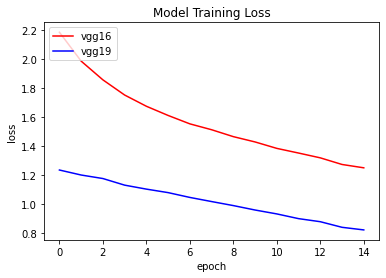

In [39]:
import matplotlib.pyplot as plt

plt.plot(history16.history['loss'],'r')
plt.plot(history19.history['loss'],'b')

plt.title('Model Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['vgg16','vgg19'], loc='upper left')
plt.show()

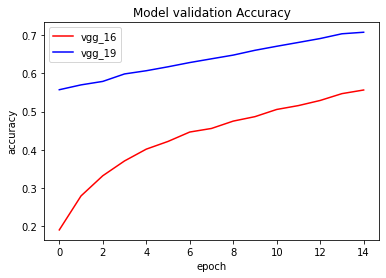

In [40]:
plt.plot(history16.history['accuracy'],'r')
plt.plot(history19.history['accuracy'],'b')

plt.title('Model validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend(['vgg_16','vgg_19'],loc='upper left')
plt.show()

이제 VGG모델로 비교를 했으니 ResNet으로 할것이다

ResNet34 Block

In [180]:
def build_resNet34_block(input_layer, num_cnn=3, channel=64, block_num=1,is_plain=False):
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        identity = x
        x = keras.layers.Conv2D(
            filters = channel, 
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters = channel, 
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  

            #skip connection
            x = keras.layers.Add()([x,identity])
        else: # plain 네트워크일 때는 identity  생략
            pass
    if identity.shape[1] != 1:    
        x = keras.layers.Conv2D(
            filters = channel, 
            kernel_size=(3,3),
            strides=2,
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_0_conv{cnn_num}'
        )(x)
        #마지막 블록에서는 MaxPooling 하지않는다
    return x



ResNet34 Model

In [289]:
def build_resNet34(input_shape=(32,32,3),
                  num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_plain=False,
                  ):
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    output=input_layer
    
    #conv1 1층
    output= keras.layers.Conv2D(filters=64,
                               kernel_size=(2,2),
                               strides =2,
                               padding='valid')(output)
    output=keras.layers.BatchNormalization()(output)
    
    #conv2_x 2층
    output=keras.layers.MaxPooling2D(pool_size=(2,2), strides=2,)(output)
    
    #block 끼울 차례
    if not is_plain:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output= build_resNet34_block(output, num_cnn=num_cnn, channel=channel, block_num=i)
    else:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output= build_resNet34_block(output, num_cnn=num_cnn, channel=channel, block_num=i,is_plain=True)
            
    output = keras.layers.AveragePooling2D(padding='same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',name='predictions')(output)
    
    model = keras.Model(inputs = input_layer, outputs=output)
    
    return model
    
    
    
    
    
    
    
    
    

In [290]:
resnet_34 = build_resNet34()
resnet_34.summary()

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_72 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_224 (Conv2D)             (None, 16, 16, 64)   832         input_72[0][0]                   
__________________________________________________________________________________________________
batch_normalization_691 (BatchN (None, 16, 16, 64)   256         conv2d_224[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_65 (MaxPooling2D) (None, 8, 8, 64)     0           batch_normalization_691[0][0]    
___________________________________________________________________________________________

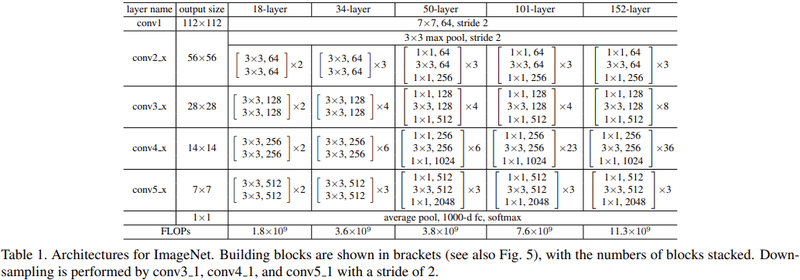

ResNet50 Block

In [291]:
def build_resNet50_block(input_layer, num_cnn=3, channel=64, block_num=1,is_plain=False):
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    
            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity) 
            identity = keras.layers.Conv2D(channel*4, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)
        #마지막 블록 뒤에서는 MaxPooling 하지않는다
    return x





ResNet50 Model

In [292]:
def build_resNet50(input_shape=(32,32,3),
                  num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_plain=False,
                  ):
    assert len(num_cnn_list) == len(channel_list)

    
    input_layer = keras.layers.Input(shape=input_shape)
    output=input_layer
    
    #conv1 1층
    output= keras.layers.Conv2D(filters=64,
                               kernel_size=(2,2),
                               strides =2,
                               padding='valid')(output)
    output=keras.layers.BatchNormalization()(output)
    #conv2_x 2층
    output=keras.layers.MaxPooling2D(pool_size=(2,2), strides=2,)(output)
    
    #block 끼울 차례
    if not is_plain:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output= build_resNet50_block(output, num_cnn=num_cnn, channel=channel, block_num=i)
    else:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output= build_resNet50_block(output, num_cnn=num_cnn, channel=channel, block_num=i,is_plain=True)
        
    output = keras.layers.AveragePooling2D(padding='same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',name='predictions')(output)
    
    model = keras.Model(inputs = input_layer, outputs=output)
    
    return model
    
    
    
    
    
    
    
    
    

In [293]:
resnet_50 = build_resNet50()
resnet_50.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_228 (Conv2D)             (None, 16, 16, 64)   832         input_73[0][0]                   
__________________________________________________________________________________________________
batch_normalization_708 (BatchN (None, 16, 16, 64)   256         conv2d_228[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_66 (MaxPooling2D) (None, 8, 8, 64)     0           batch_normalization_708[0][0]    
___________________________________________________________________________________________

진짜 별거 아닌데.. 기존 residual로 더할 x channel도 *4를 해줌으로써 Add연산에서 나타나던 오류를 없앴다.. 힘들다

plain34 model

In [184]:
plain_34 = build_resNet34(is_plain=True)

plain50 Model

In [223]:
plain_50 = build_resNet50(is_plain=True)

In [300]:
BATCH_SIZE = 256
EPOCH = 30

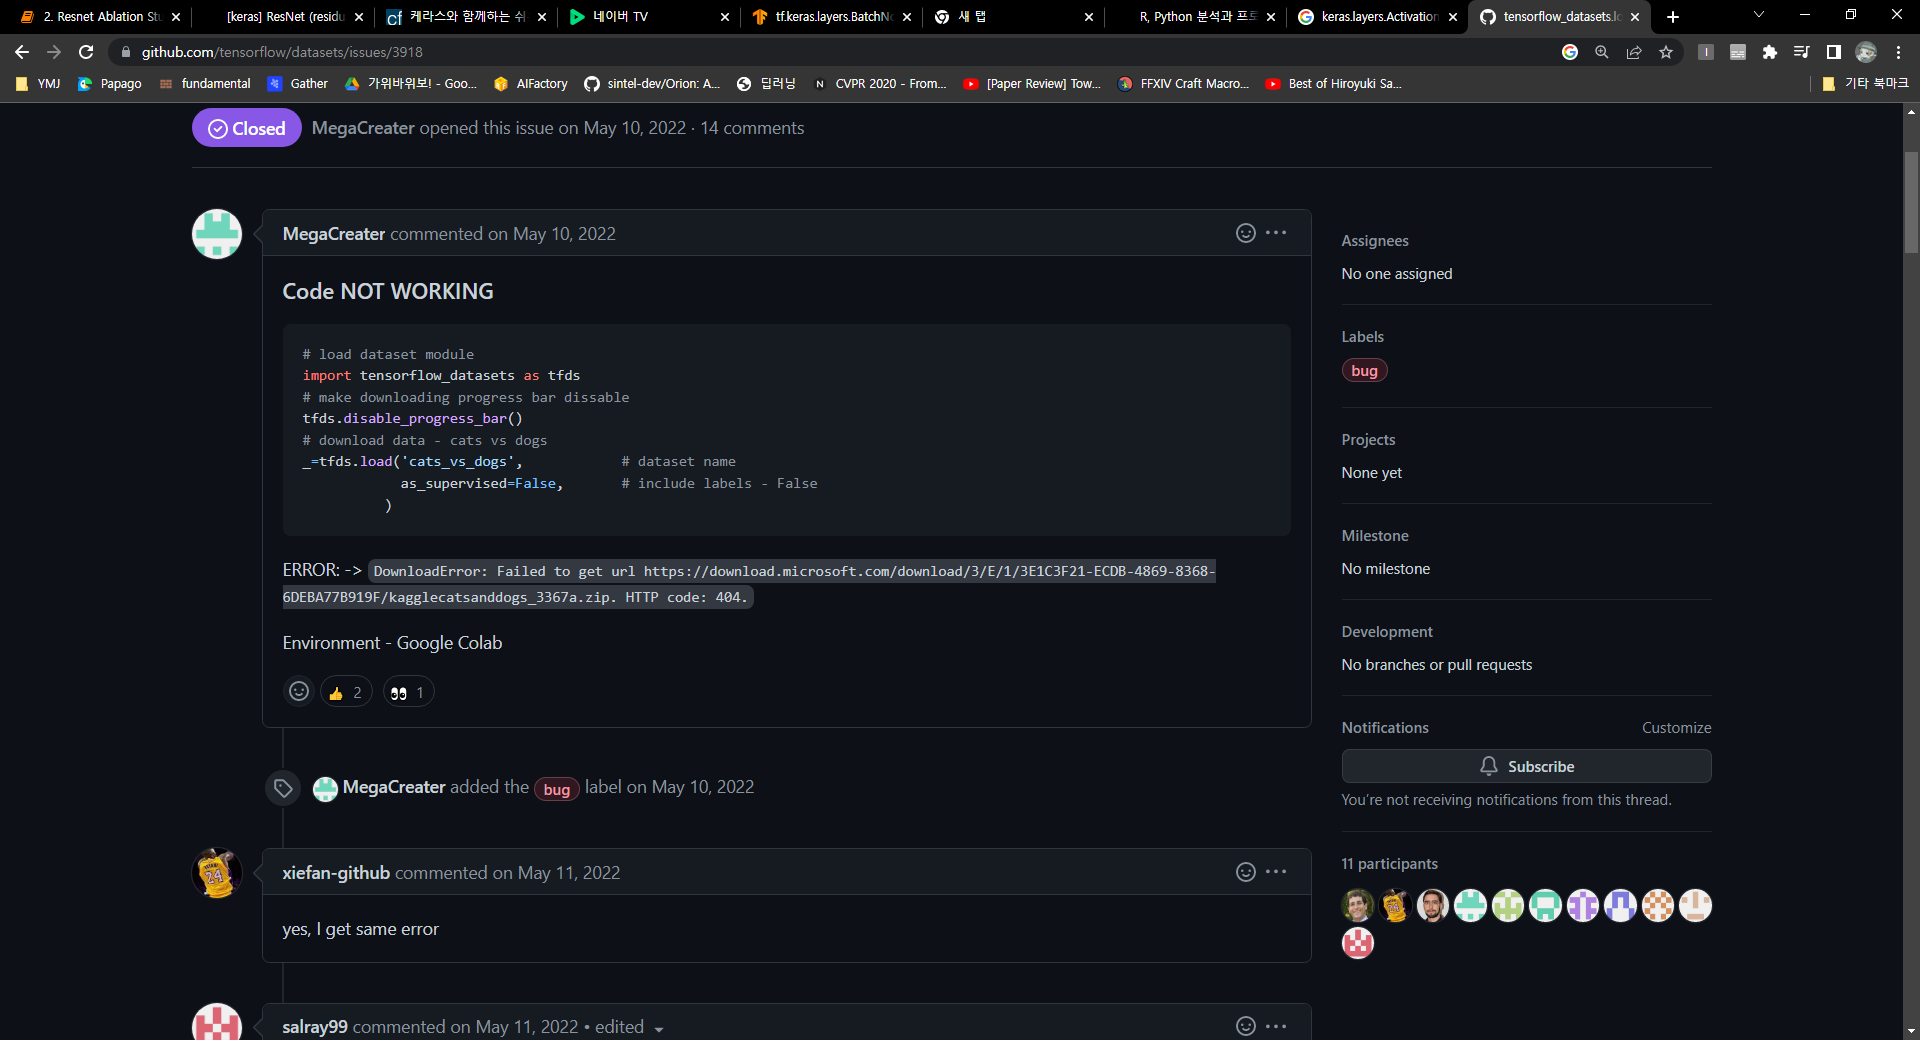
cats vs dogs는 에러가 뜬다고한다

In [226]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

엄청난 고-수가 이 setattr을 알려줘서 성공적으로 이미지를 다운로드 받을수 있게 되었다... ㄷㄷㄷㄷ

In [267]:
image_size=(224,224)

In [284]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    #split=['train[:80%]','train[80%:]'],
    split=['train','test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)



In [285]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='/aiffel/tensorflow_datasets/cifar10/3.0.2',
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple la

In [260]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    t

In [234]:
ds_test

<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int64)>

In [244]:
int(ds_info.splits['train[:80%]'].num_examples)

18610

In [276]:
ds_info.features["label"].num_classes

2

In [277]:
ds_info.features["label"].names

['cat', 'dog']

Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [139,145,3], [batch]: [350,350,3]

다음의 문제가 발생했다.. 

이미지 사이즈관련 문제가 계속 발생하는데, 일단 현재로썬 문제를 아무리 찾아봐도 해결이 안되서 기존 cifar10으로 하고자 한다

In [301]:
resnet_34.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

In [302]:
history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
195/195 [==============================] - 25s 88ms/step - loss: 0.0578 - accuracy: 0.9871 - val_loss: 2.6788 - val_accuracy: 0.5030
Epoch 2/30
195/195 [==============================] - 17s 87ms/step - loss: 0.0477 - accuracy: 0.9894 - val_loss: 2.9672 - val_accuracy: 0.4953
Epoch 3/30
195/195 [==============================] - 17s 87ms/step - loss: 0.0449 - accuracy: 0.9891 - val_loss: 3.1231 - val_accuracy: 0.4818
Epoch 4/30
195/195 [==============================] - 17s 85ms/step - loss: 0.0408 - accuracy: 0.9896 - val_loss: 3.0329 - val_accuracy: 0.5008
Epoch 5/30
195/195 [==============================] - 17s 86ms/step - loss: 0.0435 - accuracy: 0.9882 - val_loss: 3.0579 - val_accuracy: 0.5116
Epoch 6/30
195/195 [==============================] - 17s 86ms/step - loss: 0.0400 - accuracy: 0.9890 - val_loss: 3.3232 - val_accuracy: 0.4886
Epoch 7/30
195/195 [==============================] - 17s 87ms/step - loss: 0.0395 - accuracy: 0.9886 - val_loss: 3.1843 - val_accuracy:

In [303]:
plain_34.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

In [304]:
history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
195/195 [==============================] - 24s 85ms/step - loss: 1.5241 - accuracy: 0.4470 - val_loss: 1.6549 - val_accuracy: 0.3859
Epoch 2/30
195/195 [==============================] - 17s 85ms/step - loss: 1.4635 - accuracy: 0.4714 - val_loss: 1.6253 - val_accuracy: 0.4091
Epoch 3/30
195/195 [==============================] - 16s 84ms/step - loss: 1.3953 - accuracy: 0.4984 - val_loss: 1.6106 - val_accuracy: 0.4205
Epoch 4/30
195/195 [==============================] - 16s 84ms/step - loss: 1.3057 - accuracy: 0.5376 - val_loss: 1.5858 - val_accuracy: 0.4249
Epoch 5/30
195/195 [==============================] - 16s 83ms/step - loss: 1.2532 - accuracy: 0.5572 - val_loss: 1.6290 - val_accuracy: 0.4362
Epoch 6/30
195/195 [==============================] - 16s 84ms/step - loss: 1.1617 - accuracy: 0.5944 - val_loss: 1.6729 - val_accuracy: 0.4278
Epoch 7/30
195/195 [==============================] - 16s 83ms/step - loss: 1.1001 - accuracy: 0.6162 - val_loss: 1.7474 - val_accuracy:

In [305]:
resnet_50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

In [306]:
history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
195/195 [==============================] - 35s 129ms/step - loss: 1.4400 - accuracy: 0.4712 - val_loss: 1.8188 - val_accuracy: 0.3740
Epoch 2/30
195/195 [==============================] - 25s 127ms/step - loss: 1.3642 - accuracy: 0.5036 - val_loss: 1.4610 - val_accuracy: 0.4682
Epoch 3/30
195/195 [==============================] - 24s 125ms/step - loss: 1.2842 - accuracy: 0.5375 - val_loss: 1.5250 - val_accuracy: 0.4460
Epoch 4/30
195/195 [==============================] - 24s 125ms/step - loss: 1.2076 - accuracy: 0.5665 - val_loss: 1.5918 - val_accuracy: 0.4536
Epoch 5/30
195/195 [==============================] - 25s 126ms/step - loss: 1.1397 - accuracy: 0.5904 - val_loss: 1.3810 - val_accuracy: 0.5026
Epoch 6/30
195/195 [==============================] - 25s 126ms/step - loss: 1.0633 - accuracy: 0.6166 - val_loss: 1.3266 - val_accuracy: 0.5198
Epoch 7/30
195/195 [==============================] - 24s 125ms/step - loss: 0.9972 - accuracy: 0.6451 - val_loss: 3.1240 - val_ac

In [307]:
plain_50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

In [308]:
history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
195/195 [==============================] - 26s 96ms/step - loss: 2.3144 - accuracy: 0.1100 - val_loss: 2.3064 - val_accuracy: 0.1007
Epoch 2/30
195/195 [==============================] - 18s 94ms/step - loss: 2.3056 - accuracy: 0.1126 - val_loss: 2.3140 - val_accuracy: 0.1007
Epoch 3/30
195/195 [==============================] - 18s 93ms/step - loss: 2.3066 - accuracy: 0.1099 - val_loss: 2.3028 - val_accuracy: 0.1054
Epoch 4/30
195/195 [==============================] - 18s 92ms/step - loss: 2.3009 - accuracy: 0.1135 - val_loss: 2.3075 - val_accuracy: 0.1162
Epoch 5/30
195/195 [==============================] - 18s 92ms/step - loss: 2.2984 - accuracy: 0.1181 - val_loss: 2.3329 - val_accuracy: 0.1099
Epoch 6/30
195/195 [==============================] - 18s 93ms/step - loss: 2.2963 - accuracy: 0.1168 - val_loss: 2.3072 - val_accuracy: 0.1315
Epoch 7/30
195/195 [==============================] - 18s 93ms/step - loss: 2.3001 - accuracy: 0.1120 - val_loss: 2.3409 - val_accuracy:

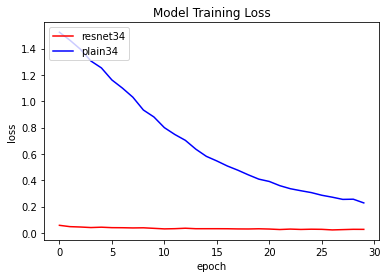

In [309]:
plt.plot(history_resnet_34.history['loss'],'r')
plt.plot(history_plain_34.history['loss'],'b')

plt.title('Model Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['resnet34','plain34'], loc='upper left')
plt.show()

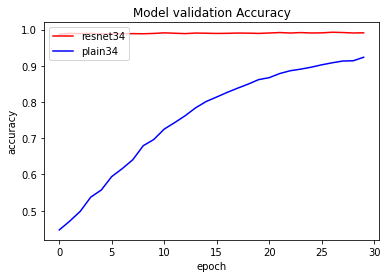

In [310]:
plt.plot(history_resnet_34.history['accuracy'],'r')
plt.plot(history_plain_34.history['accuracy'],'b')

plt.title('Model validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend(['resnet34','plain34'],loc='upper left')
plt.show()

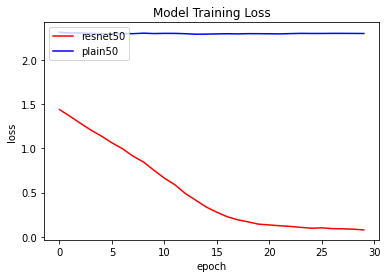

In [311]:
plt.plot(history_resnet_50.history['loss'],'r')
plt.plot(history_plain_50.history['loss'],'b')

plt.title('Model Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['resnet50','plain50'], loc='upper left')
plt.show()

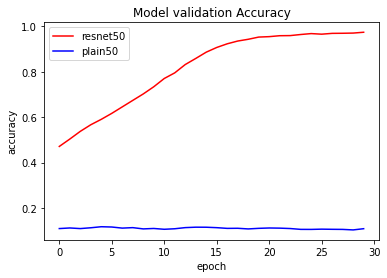

In [312]:
plt.plot(history_resnet_50.history['accuracy'],'r')
plt.plot(history_plain_50.history['accuracy'],'b')

plt.title('Model validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend(['resnet50','plain50'],loc='upper left')
plt.show()

각 Abliation Study에 대한 결과표이다

느낀점

Going Deeper에 오면서 어려워질 것이라 생각은 했지만 상상도못한 오류가 계속 찾아와서 시간이 엄청 많이 소모되는 듯 하다..

그리고 vgg16 vgg19구성과는 다른 resnet34, resnet50만의 모델구성을 수행하면서, 채널이 늘어나고 낮아짐에 따라 Add가 먹히지 않아서

residual x를 다시 conv로 channel을 늘려주었다. 이 방법이 맞는지 정확히 판단은 되지 않으나 일단 노드에 있던 예시에서 conv를 통해 

채널이 늘어난 걸 참고해서 수행하였다. 어렵다 어려워!!!

현재 에폭 15로 하고 돌리고있는데 accuracy가 낮아서 30으로 다시 돌릴 것이다



참조

1. https://hwanny-yy.tistory.com/12 

--> residual x의 Add() 참고를 위해 수행했다

